(pratica_isostasia)=
# Prática 2: Isostasia, flexura e gravidade

```{admonition} Objetivos
:class: important

1. Observar como a teoria da compensação isostática se reflete nos dados observados.
1. Aprender as técnicas práticas que são necessárias para conectar a teoria à modelagem dos dados.
1. Explorar o estado isostático de diferentes regiões do planeta.
1. Obter uma ferramenta que nos permita investigar a rigidez da placa oceânica através de dados de gravidade.
```

```{admonition} Antes de começar
:class: seealso

Esta prática depende do conteúdo das aulas:

* {ref}`litosfera`
* {ref}`gravidade`
* {ref}`isostasia`
* {ref}`pratica_grav`
```

## Bibliotecas

Vamos primeiro carregar as bibliotecas que vamos utilizar nessa prática.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xrft
import harmonica as hm
import verde as vd
import pyproj
import pygmt
import ipywidgets
import warnings

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


## Dados

Nesta prática, vamos utilizar os dados de distúrbio da gravidade, anomalia Bouguer simples e topografia que compilamos na prática passada.

In [2]:
dados = xr.load_dataset("dados.nc")
dados

<xarray.Dataset>
Dimensions:     (longitude: 2161, latitude: 1081)
Coordinates:
  * longitude   (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude    (latitude) float64 -90.0 -89.83 -89.67 ... 89.67 89.83 90.0
    height      (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Data variables:
    gravidade   (latitude, longitude) float32 9.801e+05 9.801e+05 ... 9.802e+05
    disturbio   (latitude, longitude) float64 -35.84 -35.84 ... 15.16 15.16
    topografia  (latitude, longitude) float32 2.742e+03 2.742e+03 ... -4.237e+03
    bouguer     (latitude, longitude) float64 -339.5 -339.5 ... 303.7 303.7

## Bouguer vs topografia

Como vimos na aula teórica, nos casos em que há compensação isostática segundo o modelo de Airy esperamos que a anomalia Bouguer possua uma **relação linear** com a topografia. Vamos verificar se isso é verdade para a Terra como um todo utilizando nossos dados.

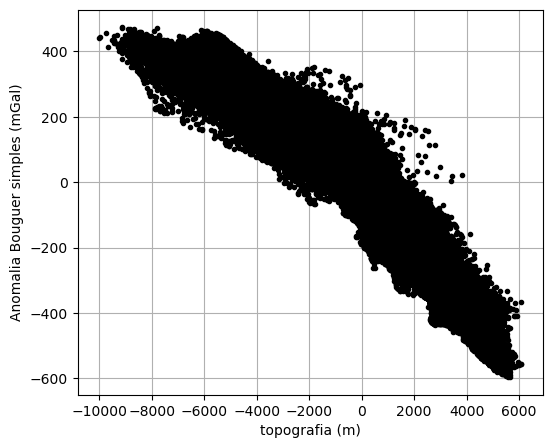

In [3]:
plt.figure(figsize=(6, 5))
plt.plot(dados.topografia.values.ravel(), dados.bouguer.values.ravel(), ".k")
plt.xlabel("topografia (m)")
plt.ylabel("Anomalia Bouguer simples (mGal)")
plt.grid()

A princípio parece que sim! Vamos calcular o valor teórico predito para ser se nosso modelo se ajusta aos dados. Lembrando que:

* Nos **continentes**: $ \delta g_{bg} = - 2 \pi G \rho_c h $
* Nos **oceanos**: $ \delta g_{bg} = - 2 \pi G (\rho_c - \rho_w) h $
* Constante gravitacional: $G = 6.67430 \times 10^{-11}\ m^3 kg^{-1} s^{-2}$

In [4]:
def bouguer_airy(topografia, densidade_crosta_continental, densidade_crosta_oceanica, densidade_agua):
    """
    Calcula a anomalia Bouguer prevista por um modelo de Airy.
    """
    G = 6.67430e-11
    bouguer = xr.where(
        topografia >= 0,
        1e5 * -2 * np.pi * G * densidade_crosta_continental * topografia,
        1e5 * -2 * np.pi * G * (densidade_crosta_oceanica - densidade_agua) * topografia,
    )
    return bouguer

Com essa função, podemos prever os dados de anomalia Bouguer utilizando densidades médias para a crosta. 

In [5]:
previsto = bouguer_airy(
    dados.topografia, 
    densidade_crosta_continental=2700, 
    densidade_crosta_oceanica=2800, 
    densidade_agua=1000,
)

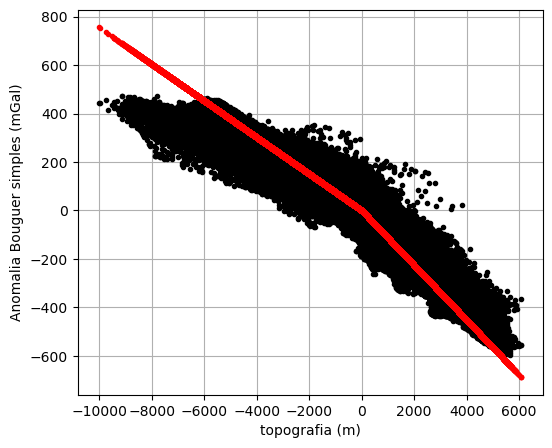

In [6]:
plt.figure(figsize=(6, 5))
plt.plot(dados.topografia.values.ravel(), dados.bouguer.values.ravel(), ".k")
plt.plot(dados.topografia.values.ravel(), previsto.values.ravel(), ".r")
plt.xlabel("topografia (m)")
plt.ylabel("Anomalia Bouguer simples (mGal)")
plt.grid()

:::{admonition} 💬 **Discussão**
:class: tip

Com base na figura acima 👆🏽, discuta em grupos de 2-3:

1. Quais ambientes tectônicos são responsáveis pelo desajuste no canto superior esquerdo e inferior direito da figura? 
1. Qual é uma possível explicação geofísica/tectônica para esse desajuste?

:::

::::{admonition} 🧘 **Sua vez: O que acontece nas dorsais?** 
:class: tip

As dorsais estão em equilíbrio isostático, como vimos no mapa do distúrbio da gravidade na aula passada. Porém, o modelo Airy não é adequado para explicar a compensação isostática das dorsais.

1. Qual modelo de compensação explica o equilíbrio nas dorsais?
1. Derive a relação entre topografia e anomalia Bouguer para esse modelo e a implemente em uma função.
1. Selecione uma parcela dos dados que contém uma dorsal e aplique seu modelo.
1. O modelo ajusta os dados? Como esse modelo difere da previsão utilizando Airy?
1. Qual é uma possível interpretação geológica/geofísica qu justifica o uso do modelo Pratt?

::::

## Ilhas oceânicas

Uma das regiões que podemos identificar pelo mapa do distúrbio da gravidade como não estando compensadas isostaticamente são as ilhas oceânicas como o Havaí. 

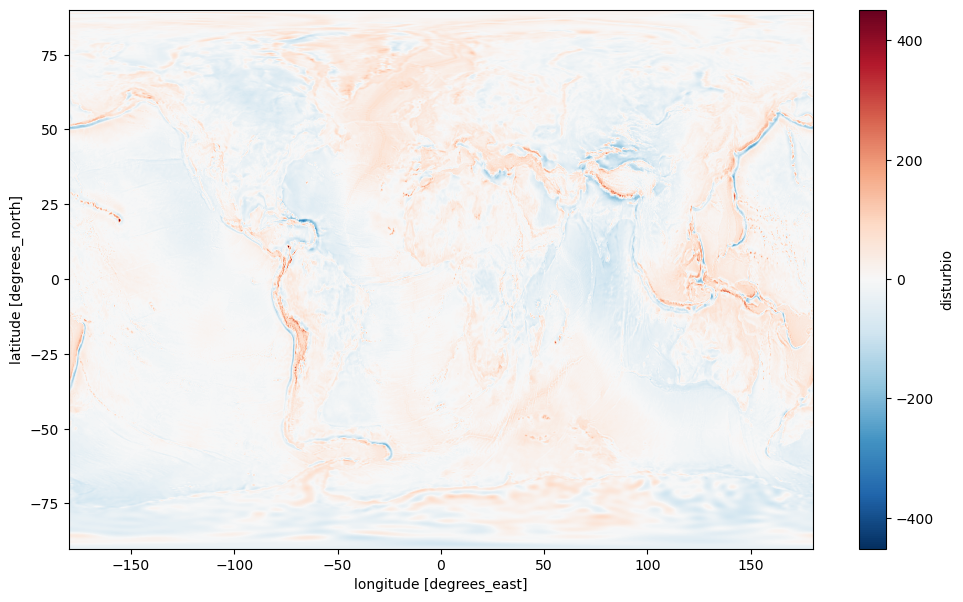

In [7]:
plt.figure(figsize=(12, 7))
dados.disturbio.plot()

Vamos isolar os dados em torno o arquipélago Havaiano para ter uma ideia melhor dos valores de topografia e distúrbio da gravidade.

In [8]:
havai = dados.sel(longitude=slice(-180, -150), latitude=slice(15, 30))

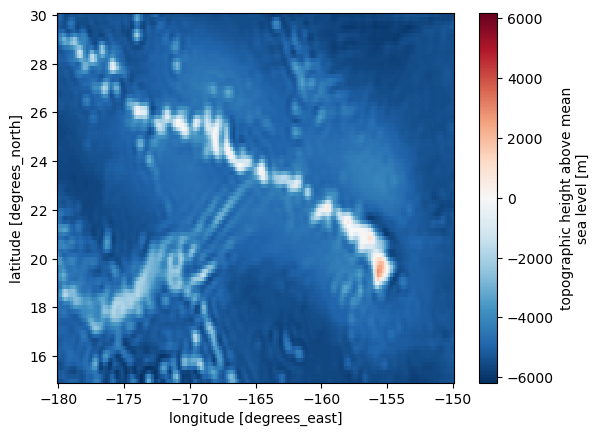

In [9]:
havai.topografia.plot()

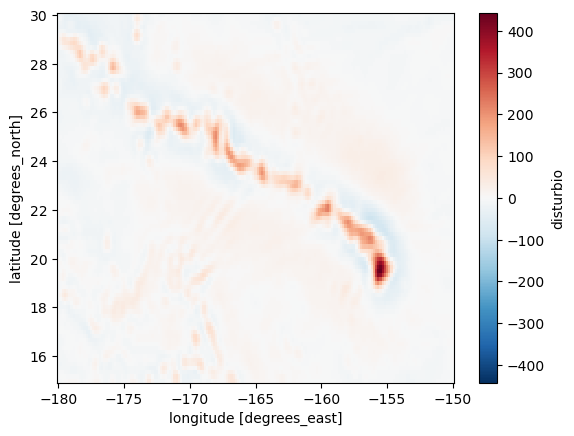

In [10]:
havai.disturbio.plot()

Podemos verificar pelo gráfico de anamolia Bouguer por topografia que essa região não está compensada por um mecanismo Airy ou Pratt.

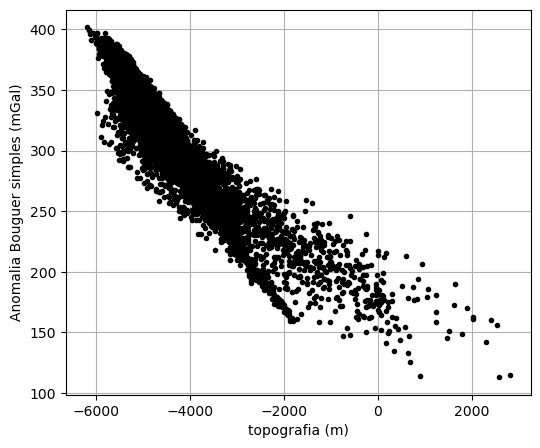

In [11]:
plt.figure(figsize=(6, 5))
plt.plot(havai.topografia.values.ravel(), havai.bouguer.values.ravel(), ".k")
plt.xlabel("topografia (m)")
plt.ylabel("Anomalia Bouguer simples (mGal)")
plt.grid()

## Flexura da litosfera oceânica

A topografia elevada das ilhas oceânicas é sustentada pela própria rigidez da placa oceânica, que se deforma sob a carga das ilhas. Como vimos na aula teórica, nós podemos modelar essa deformação (a flexura) através da solução de uma equação diferencial utilizando a transformada rápida de Fourier (FFT).

A aplicação da FFT necessita dados em coordenadas cartesianas. Logo, primeiro devemos projetar nossos dados. Aqui utilizarmos uma projeção Mercator. No final, teremos nossos dados com coordenadas Leste e Norte em metros.

In [12]:
merc = pyproj.Proj(proj="merc")
topografia = vd.project_grid(havai.topografia, merc, method="nearest")
disturbio = vd.project_grid(havai.disturbio, merc, method="nearest")
topografia

<xarray.DataArray 'topografia' (northing: 91, easting: 181)>
array([[-5333.  , -5333.  , -5159.5 , ..., -5477.25, -5390.5 , -5390.5 ],
       [-5333.  , -5333.  , -5159.5 , ..., -5477.25, -5390.5 , -5390.5 ],
       [-5277.  , -5182.  , -5181.5 , ..., -5401.  , -5352.5 , -5352.5 ],
       ...,
       [-5247.  , -5199.  , -5417.5 , ..., -5476.  , -5317.  , -5317.  ],
       [-5159.  , -5034.  , -5406.  , ..., -5701.  , -5586.  , -5586.  ],
       [-5096.5 , -5096.5 , -5282.  , ..., -5712.  , -5707.5 , -5707.5 ]],
      dtype=float32)
Coordinates:
  * easting   (easting) float64 -2.004e+07 -2.002e+07 ... -1.672e+07 -1.67e+07
  * northing  (northing) float64 1.678e+06 1.698e+06 ... 3.462e+06 3.482e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

Em seguida, precisamos calcular somente o desvio da topografia com relação a uma batimetria mediana. Isso é necessário para alinhar nossos dados com o que o nosso modelo matemático espera.

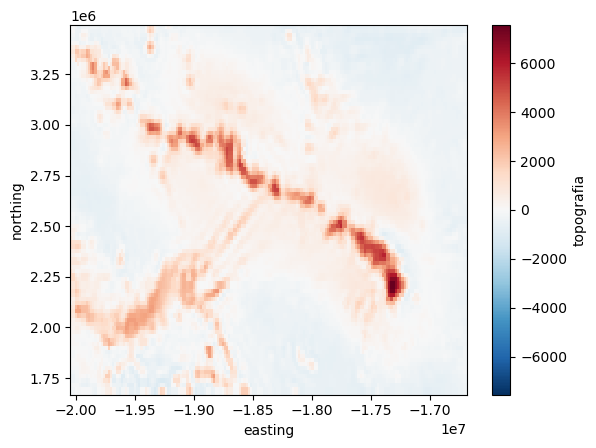

In [13]:
topografia_mediana = np.median(topografia)
topografia_residual = topografia - topografia_mediana
topografia_residual.plot()

Uma feição comum em ilhas oceânicas associadas com *hotspots* é um inchaço da crosta ao redor das ilhas (**thermal swell**) que é atribuído à dilatação térmica da litosfera causada pelo hotspot. Isso não faz parte do nosso modelo de flexura e então precisamos removê-lo antes da nossa modelagem. Faremos isso com um **filtro passa-alta** para remover esse efeito de longo comprimento de onda.

/home/leo/bin/conda/envs/aula2023/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


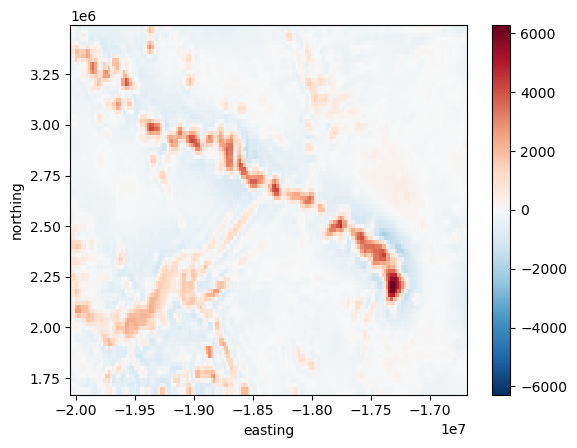

In [14]:
topografia_residual = hm.gaussian_highpass(topografia_residual, wavelength=1e6)
topografia_residual.plot()

Agora podemos calcular o filtro no domínio da frequência entre a topografia e a flexura:

$$
W(k_x, k_y) = \dfrac{-(\rho_c - \rho_w)}{(\rho_m - \rho_c)}\left[1 + \dfrac{D(2\pi k)^4}{g(\rho_m - \rho_c)}\right]^{-1} T(k_x, k_y)
$$

$$k = \sqrt{k_x^2 + k_y^2}$$

In [15]:
def filtro_flexura(
    kx, ky, Te, densidade_crosta=2800, densidade_agua=1000, densidade_manto=3300, 
    young=6.5e10, poisson=0.25, gravidade=9.8,
):
    """
    Calcula o filtro da flexura no domínio da frequência.
    """
    D = young * Te ** 3 / (
        12 * (1 - poisson ** 2)
    )
    k = np.sqrt(ky**2 + kx**2)
    filtro = (
        -(densidade_crosta - densidade_agua) 
        / (densidade_manto - densidade_crosta) 
        * 1 / (
            1 + (D * (2 * np.pi * k)**4)
            / (gravidade * (densidade_manto - densidade_crosta))
        )
    )
    return filtro

Agora podemos aplicar a FFT aos dados de topografia para realizar a modelagem. 

In [16]:
topografia_ft = xrft.fft(topografia_residual, true_amplitude=True, true_phase=True)

In [17]:
def mapa_flexura(Te):
    "Calcula a flexura para o Te dado e gera um mapa"
    flexura_ft = filtro_flexura(
        topografia_ft.freq_easting, 
        topografia_ft.freq_northing, 
        Te=Te * 1e3,
    ) * topografia_ft
    flexura = xrft.ifft(
        flexura_ft, 
        true_amplitude=True, 
        true_phase=True,
    ).real
    flexura.plot()
    
warnings.simplefilter("ignore")
ipywidgets.interact(mapa_flexura, Te=(0, 150, 10))

interactive(children=(IntSlider(value=70, description='Te', max=150, step=10), Output()), _dom_classes=('widge…

<function __main__.mapa_flexura(Te)>

::::{admonition} 🧘 **Sua vez: A espessura elástica efetiva** 
:class: tip

A espessura elástica efetiva controla a forma da flexura da litosfera oceânica. Utilizando a figura interativa acima, responda:

1. Qual é o efeito que aumentar ou diminuir $T_e$ tem na flexura estimada?
1. Quando $T_e = 0$, o que acontece com nosso modelo de flexura? Observe tanto o resultado acima quanto a equação do filtro de flexura acima.
1. Dada a questão anterior, qual relação você espera que exista entre $T_e$ e o distúrbio da gravidade sobre as ilhas?

::::

## Distúrbio da gravidade versus topografia

Vimos também em aula que podemos calcular o distúrbio da gravidade causado pela flexura assumindo que a Moho é deformada da mesma forma que a batimetria. Como temos dados de gravidade, podemos aplicar a FFT aos dados do distúrbio e dividir pela FFT da topografia. Essa operação estima o **valor do filtro entre a topografia e o distúrbio**, que podemos modelar com a equação:

$$
\phi(k_x, k_y) = 2 \pi G (\rho_c - \rho_w) e^{-2\pi k s} \left\{ 1 -  \left[1 + \dfrac{D(2\pi k)^4}{g(\rho_m - \rho_c)}\right]^{-1}e^{-2\pi k d} \right\}
$$

Mas antes disso, precisamos remover o efeito do *swell* dos nossos dados de distúrbio da gravidade, como fizemos para a topografia.

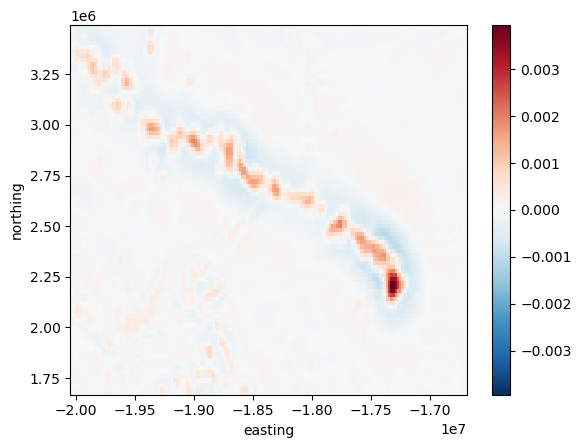

In [18]:
disturbio_residual = hm.gaussian_highpass(disturbio * 1e-5, wavelength=1e6)
disturbio_residual.plot()

Agora podemos aplicar a FFT e estimar o filtro observado como função do número de onda.

Text(0.5, 0, 'Número de onda (1/m)')

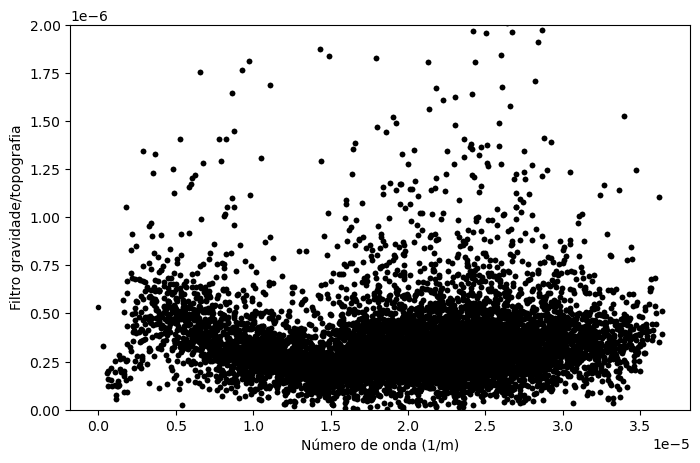

In [19]:
disturbio_ft = xrft.fft(disturbio_residual, true_amplitude=True, true_phase=True)
filtro_observado = disturbio_ft / topografia_ft
k = np.sqrt(topografia_ft.freq_northing**2 + topografia_ft.freq_easting**2)

plt.figure(figsize=(8, 5))
plt.plot(k.values.ravel(), np.abs(filtro_observado).values.ravel(), ".k")
plt.ylim(0, 0.000002)
plt.ylabel("Filtro gravidade/topografia")
plt.xlabel("Número de onda (1/m)")

Nos altos números de onda, o filtro apresenta um comportamento disperso. Isso pode estar associado às diversas **zonas de falhas transformantes** que estão presentes na região e não obedecem a relação da flexura.

Vamos calcular o valor predito do filtro e comparar com as observações.

In [20]:
def filtro_flexura_grav(
    kx, ky, Te, distancia, espessura_crosta,
    densidade_crosta=2800, densidade_agua=1000, densidade_manto=3300, 
    young=6.5e10, poisson=0.25, gravidade=9.8,
):
    """
    Calcula o filtro para prever grav causado pela flexura.
    """
    G = 6.67430e-11
    D = young * Te ** 3 / (
        12 * (1 - poisson ** 2)
    )
    k = np.sqrt(ky**2 + kx**2)
    filtro = (
        2 * np.pi * G * (densidade_crosta - densidade_agua)
        * np.exp(-2 * np.pi * k * distancia) * (
            1 - 1 / (
                1 + (D * (2 * np.pi * k)**4)
                / (gravidade * (densidade_manto - densidade_crosta))
            ) * np.exp(-2 * np.pi * k * espessura_crosta)
        )
    )
    return filtro

In [21]:
def grafico_filtro_grav_topo(Te):
    filtro_predito = filtro_flexura_grav(    
        topografia_ft.freq_easting, 
        topografia_ft.freq_northing, 
        Te=Te * 1e3,
        distancia=10e3 + np.abs(topografia_mediana),
        espessura_crosta=6e3,
    )

    plt.figure(figsize=(8, 5))
    plt.plot(k.values.ravel(), np.abs(filtro_observado).values.ravel(), ".k")
    plt.plot(k.values.ravel(), np.abs(filtro_predito).values.ravel(), ".r")
    plt.ylim(0, 0.000002)
    plt.xlabel("Filtro gravidade/topografia")
    plt.ylabel("Número de onda (1/m)")
    
ipywidgets.interact(grafico_filtro_grav_topo, Te=(0, 100, 5))

interactive(children=(IntSlider(value=50, description='Te', step=5), Output()), _dom_classes=('widget-interact…

<function __main__.grafico_filtro_grav_topo(Te)>

Como podemos ver, o filtro observado pode ser utilizado para **estimar a espessura elástica efetiva** da litosfera oceânica.